## **1. Import libraries**

In [1]:
!pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 852.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 93.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.5 MB/s eta 0:00:00


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
from sklearn.datasets import fetch_openml

RANDOM_SEED = 59
np.random.seed(RANDOM_SEED)

## **2. Prepare dataset**

In [57]:
X_raw = None
y_raw = None
loaded_from = None

# Load data
try:
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_raw = np.concatenate([X_train, X_test], axis=0)
    y_raw = np.concatenate([y_train, y_test], axis=0).astype(int)
    loaded_from = "tensorflow.keras.datasets.mnist"
except Exception:
    try:
        mnist_ = fetch_openml('mnist_784', version=1, as_frame=False)
        # 28, 28 mean
        X_raw = mnist_.data.reshape(-1, 28, 28)
        y_raw = mnist_.target.astype(int)
    except Exception as e:
        raise RuntimeError(
            "Failed to load MNIST via both TensorFlow and OpenML."
        ) from e
print(f"Loaded MNIST from: {loaded_from}")
print("Raw shapes:", X_raw.shape, y_raw.shape)

Loaded MNIST from: tensorflow.keras.datasets.mnist
Raw shapes: (70000, 28, 28) (70000,)


In [58]:
#Flatten X
X_flat = X_raw.reshape(X_raw.shape[0], -1).astype(np.float32)
X_flat /=255

# Add bias column: X[:, 0] = 1
N, D_no_bias = X_flat.shape
X = np.zeros((N, D_no_bias + 1), dtype=np.float32)
X[:, 0] = 1.0
X[:, 1:] = X_flat

y = y_raw.astype(int)

print(f'X shape (with bias): {X.shape}')
print(f'y shape: {y.shape}, classes: {sorted(np.unique(y))}')

X shape (with bias): (70000, 785)
y shape: (70000,), classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


## **3. Train/Val/Test split**



In [59]:
val_size = 0.2
test_size = 0.125
RANDOM_STATE = 42
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=RANDOM_STATE,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=RANDOM_STATE,
    shuffle=is_shuffle
)
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 49000
Number of val samples: 14000
Number of test samples: 7000


## **4. Normalization**

In [60]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [61]:
X_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## **5. Define essential functions**

### **5.1. Sigmoid function**

In [62]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### **5.2. Binary loss function**

In [63]:
def compute_loss_bce(y_hat, y):
    y_hat = np.clip(
        y_hat, 1e-7, 1 - 1e-7
    )

    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

In [64]:
def compute_multiclass_ova_loss(probs, y_true, n_classes=10):
    B = y_true.shape[0]
    total = 0.0
    for k in range(n_classes):
        yk = (y_true == k).astype(np.float32)
        total += compute_loss_bce(probs[:, k], yk)

    return total / n_classes

### **5.3. Hypothesis function**

In [65]:
def predict_ova(X, theta):
    logits = X @ theta.T
    probs = sigmoid(logits)

    return probs

### **5.4. Gradient function**

In [67]:
def compute_gradient_ova(X, y_true, probs, n_classes=10):
    B, D = X.shape
    grads = np.zeros((n_classes, D), dtype=np.float32)
    for k in range(n_classes):
        yk = (y_true == k).astype(np.float32)
        yhat_k = probs[:, k]
        grads[k] = (X.T @ (yhat_k - yk)) / B

    return grads

### **5.5. Update weights function**

In [68]:
def update_theta(theta, gradient, lr):
    return theta - lr * gradient

### **5.6. Accuracy function**

In [69]:
def compute_accuracy_multiclass(X, y_true, theta):
    probs = predict_ova(X, theta)
    y_pred = probs.argmax(axis=1)

    return (y_pred == y_true).mean()

## **6. Training**

In [70]:
# Hyperparameters
lr = 0.1
epochs = 20
batch_size = 256
n_classes = 10

np.random.seed(RANDOM_STATE)

theta = np.random.uniform(
    low=-0.01, high=0.01,
    size=(n_classes, X_train.shape[1])
).astype(np.float32)

In [71]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

num_train = X_train.shape[0]

for epoch in range(epochs):
    idx = np.arange(num_train)
    np.random.shuffle(idx)
    X_train_shuffle = X_train[idx]
    y_train_shuffle = y_train[idx]

    batch_losses = []
    for i in range(0, num_train, batch_size):
        Xb = X_train_shuffle[i: i + batch_size]
        yb = y_train_shuffle[i: i + batch_size]

        # Forward (OvA)
        probs_b = predict_ova(Xb, theta)
        # Loss (macro over K)
        loss_b = compute_multiclass_ova_loss(probs_b, yb, n_classes=n_classes)
        batch_losses.append(loss_b)

        # Backward (OvA)
        grads = compute_gradient_ova(Xb, yb, probs_b, n_classes=n_classes)

        # Update
        theta = update_theta(theta, grads, lr)
    probs_train = predict_ova(X_train, theta)
    train_loss = compute_multiclass_ova_loss(probs_train, y_train, n_classes=n_classes)
    train_acc  = compute_accuracy_multiclass(X_train, y_train, theta)

    probs_val = predict_ova(X_val, theta)
    val_loss = compute_multiclass_ova_loss(probs_val, y_val, n_classes=n_classes)
    val_acc  = compute_accuracy_multiclass(X_val, y_val, theta)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"EPOCH {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

EPOCH 01 | Train Loss: 0.1243 | Val Loss: 0.1260 | Train Acc: 0.8807 | Val Acc: 0.8771
EPOCH 02 | Train Loss: 0.0958 | Val Loss: 0.0984 | Train Acc: 0.8935 | Val Acc: 0.8879
EPOCH 03 | Train Loss: 0.0855 | Val Loss: 0.0889 | Train Acc: 0.8996 | Val Acc: 0.8946
EPOCH 04 | Train Loss: 0.0793 | Val Loss: 0.0831 | Train Acc: 0.9049 | Val Acc: 0.8976
EPOCH 05 | Train Loss: 0.0755 | Val Loss: 0.0799 | Train Acc: 0.9083 | Val Acc: 0.9010
EPOCH 06 | Train Loss: 0.0729 | Val Loss: 0.0774 | Train Acc: 0.9094 | Val Acc: 0.9024
EPOCH 07 | Train Loss: 0.0709 | Val Loss: 0.0760 | Train Acc: 0.9118 | Val Acc: 0.9034
EPOCH 08 | Train Loss: 0.0695 | Val Loss: 0.0749 | Train Acc: 0.9116 | Val Acc: 0.9016
EPOCH 09 | Train Loss: 0.0683 | Val Loss: 0.0740 | Train Acc: 0.9141 | Val Acc: 0.9038
EPOCH 10 | Train Loss: 0.0671 | Val Loss: 0.0730 | Train Acc: 0.9153 | Val Acc: 0.9061
EPOCH 11 | Train Loss: 0.0664 | Val Loss: 0.0725 | Train Acc: 0.9160 | Val Acc: 0.9066
EPOCH 12 | Train Loss: 0.0656 | Val Loss: 0

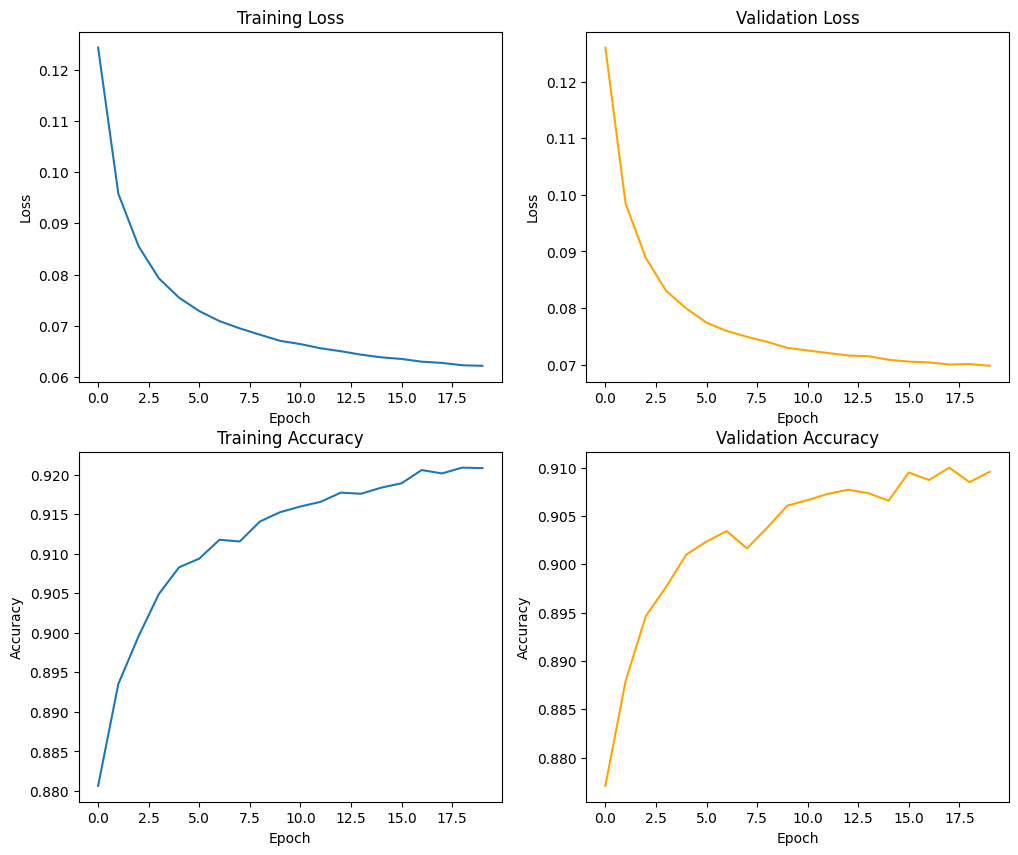

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **7. Evaluation**

In [73]:
# Val set
val_acc = compute_accuracy_multiclass(X_val, y_val, theta)
print('Evaluation on validation set:')
print(f'Accuracy: {val_acc:.4f}')

Evaluation on validation set:
Accuracy: 0.9096


In [74]:
# Test set
test_acc = compute_accuracy_multiclass(X_test, y_test, theta)
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.4f}')

Evaluation on test set:
Accuracy: 0.9023
